In [1]:
import numpy as np
from numpy.ma import masked_values as maval
import gsw
import xarray as xr
import pandas as pd
import os.path as op
from datetime import datetime, timedelta
from scipy.interpolate import PchipInterpolator as pchip
from scipy.interpolate import interp1d
from scipy.signal import medfilt
import scipy.stats as stats
import dask.array as dsar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import matplotlib.colors as clr
import matplotlib.ticker as tick
import matplotlib.path as mpath
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
ddir = '/swot/SUM02/takaya/SOCLIM'

In [3]:
siodir = '/swot/SUM02/takaya/SOCCOM/SIO'
pf = pd.read_csv(op.join(siodir,'../Fronts/pf.txt'), delim_whitespace=True, 
                 nrows=968, header=None, dtype=float, names=['lon','lat'])
saf = pd.read_csv(op.join(siodir,'../Fronts/saf.txt'), delim_whitespace=True, 
                 nrows=1079, header=None, dtype=float, names=['lon','lat'])
saccf = pd.read_csv(op.join(siodir,'../Fronts/saccf.txt'), delim_whitespace=True, 
                   nrows=995, header=None, dtype=float, names=['lon','lat'])
stf = pd.read_csv(op.join(siodir,'../Fronts/stf.txt'), delim_whitespace=True, 
                 nrows=325, header=None, dtype=float, names=['lon','lat'])
sbdy = pd.read_csv(op.join(siodir,'../Fronts/sbdy.txt'), delim_whitespace=True, 
                  nrows=501, header=None, dtype=float, names=['lon','lat'])

In [7]:
ds = xr.open_dataset(op.join(ddir,'690%4d_Mprof.nc' % (2739)))
ds

<xarray.Dataset>
Dimensions:                            (N_CALIB: 1, N_HISTORY: 0, N_LEVELS: 2265, N_PARAM: 5, N_PROF: 2042)
Dimensions without coordinates: N_CALIB, N_HISTORY, N_LEVELS, N_PARAM, N_PROF
Data variables:
    DATA_TYPE                          object ...
    FORMAT_VERSION                     object ...
    HANDBOOK_VERSION                   object ...
    REFERENCE_DATE_TIME                object ...
    DATE_CREATION                      object ...
    DATE_UPDATE                        object ...
    PLATFORM_NUMBER                    (N_PROF) object ...
    PROJECT_NAME                       (N_PROF) object ...
    PI_NAME                            (N_PROF) object ...
    STATION_PARAMETERS                 (N_PROF, N_PARAM) object ...
    CYCLE_NUMBER                       (N_PROF) float64 ...
    DIRECTION                          (N_PROF) object ...
    DATA_CENTRE                        (N_PROF) object ...
    DC_REFERENCE                       (N_PROF) object ...

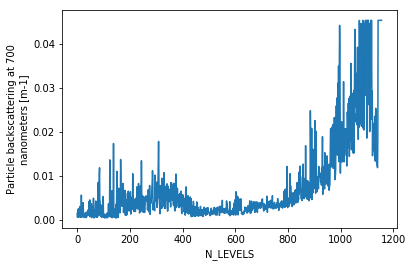

In [28]:
ds.BBP700[1308].T.plot()

In [50]:
Np, Nl = ds.PRES.shape
lat = ds.LATITUDE
lon = ds.LONGITUDE
p = ds.PRES.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.PRES_QC,dtype=float),
                                                            0.),3.),4.),6.),7.), 
                              dims=ds.PRES_QC.dims, coords=ds.PRES_QC.coords)<9.)
p = np.ma.masked_invalid(p.where(p!=99999.).where(p>0.))
maskp = np.ma.masked_invalid(p).mask
par = ds.DOWNWELLING_PAR.where(xr.DataArray(maval(maval(maval(maval(np.asarray(ds.DOWNWELLING_PAR_QC, dtype=float),
                                                                   3.),4.),6.),7.), 
                                           dims=ds.DOWNWELLING_PAR_QC.dims, 
                                           coords=ds.DOWNWELLING_PAR_QC.coords)<9.)
par = np.ma.masked_invalid(medfilt(par.where(par!=99999.).where(par>0.),5))
maskpar = par.mask
            
t = ds.TEMP.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.TEMP_QC,dtype=float),
                                                            0.),3.),4.),6.),7.), 
                              dims=ds.TEMP_QC.dims, coords=ds.TEMP_QC.coords)<9.)
t = t.where(t!=99999.)
s = ds.PSAL.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.PSAL_QC,dtype=float),
                                                            0.),3.),4.),6.),7.), 
                              dims=ds.PSAL_QC.dims, coords=ds.PSAL_QC.coords)<9.)
s = s.where(s!=99999.).where(s>0.)
SA = xr.apply_ufunc(gsw.SA_from_SP,s,p,lon,lat)
pt = xr.apply_ufunc(gsw.pt0_from_t,SA,t,p)
CT = xr.apply_ufunc(gsw.CT_from_pt,SA,pt)
n2, pN2 = gsw.Nsquared(SA.data,CT.data,p.data,lat=lat.data[:,np.newaxis],axis=1)
n2 = np.ma.masked_invalid(n2)
rho = np.ma.masked_invalid(xr.apply_ufunc(gsw.rho,SA,CT,0))
maskN = n2.mask
maskr = rho.mask


### BBP700 ###
bp700 = ds.BBP700.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.BBP700_QC,dtype=float),
                                                            0.),3.),4.),6.),7.), 
                                    dims=ds.BBP700_QC.dims, coords=ds.BBP700_QC.coords)<9.
                       ).where(ds.BBP700!=99999.)
bp700[1308] = np.nan
bp700 -= np.nanmedian(bp700.where(p>=600))
bp700 = np.ma.masked_invalid(medfilt(bp700.where(bp700>0.),5))
chl = ds.CHLA_ADJUSTED.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.CHLA_ADJUSTED_QC,
                                                                                  dtype=float),
                                                                       0.),3.),4.),6.),7.), 
                                         dims=ds.CHLA_ADJUSTED_QC.dims, coords=ds.CHLA_ADJUSTED_QC.coords)<9.
                            ).where(ds.CHLA_ADJUSTED!=99999.)
chl -= np.nanmedian(chl.where(p>=600))
chl = np.ma.masked_invalid(medfilt(chl.where(chl>0.),5))
bp470 = bp700 * (470/700)**-.78
chl = np.ma.masked_invalid(np.ma.masked_less_equal(chl,.02))
maskc = chl.mask
bp470 = np.ma.masked_greater(np.ma.masked_array(bp470, mask=maskc),0.01)
            
Cphyto = 12128*bp470 + .59
maskC = Cphyto.mask

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater_equal


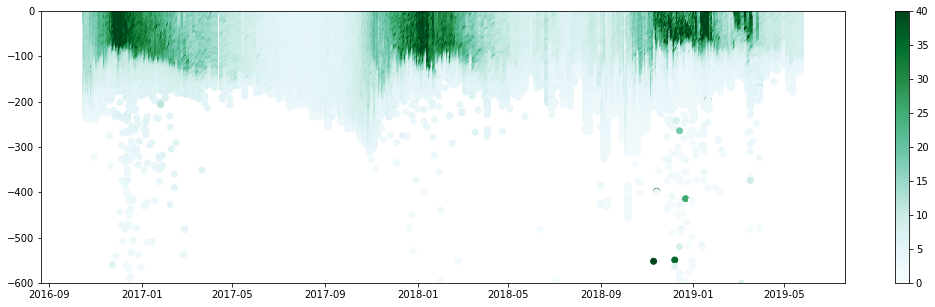

In [41]:
fig, ax = plt.subplots(figsize=(18,5))
im = ax.scatter(np.repeat(np.asarray(ds.JULD,dtype=np.datetime64).reshape((len(ds.N_PROF),1)), len(ds.N_LEVELS), axis=1), 
               -ds.PRES, c=Cphyto, cmap='BuGn', vmin=0., vmax=40.)
ax.set_ylim([-6e2,0])
fig.colorbar(im, ax=ax)

In [51]:
pnew = np.append(np.arange(4,100,4),np.arange(100,1010,10))
pMLD = np.empty(len(ds.N_PROF))
Chl = np.empty((len(ds.N_PROF),len(pnew)))
Rho = np.empty((len(ds.N_PROF),len(pnew)))
N2 = np.empty((len(ds.N_PROF),len(pnew)))
C = np.empty((len(ds.N_PROF),len(pnew)))

for i in range(len(ds.N_PROF)):
    if len(chl[i].compressed()) > 1:
        func1 = pchip(np.ma.masked_array(p,maskc)[i].compressed(),
                     np.ma.masked_array(chl,maskp)[i].compressed(),extrapolate=False)
        Chl[i] = func1(pnew)
    else:
        Chl[i] = np.ones(len(pnew))*np.nan
        
    if len(rho[i].compressed()) > 1:
        for j in range(len(ds.N_LEVELS)):
            if ~np.isnan(rho.data[i,j]):
                top = j
                break
        if p[i,top]<=2e1:
            itop = int(np.argmin(np.abs(p[i]-10.)))
            if ~np.isnan(rho[i,itop]):
                pMLD[i] = p[i,itop+np.nanargmin(np.abs((rho[i,itop:]-rho[i,itop])-0.03))]
            else:
                pMLD[i] = np.nan
        else:
            pMLD[i] = np.nan
        func2 = pchip(np.ma.masked_array(p,maskr)[i].compressed(),
                     np.ma.masked_array(rho,maskp)[i].compressed(),extrapolate=False)
        Rho[i] = func2(pnew)
    else:
        pMLD[i] = np.nan
        Rho[i] = np.ones(len(pnew))*np.nan
            
    if len(Cphyto[i].compressed()) > 1:
        func3 = pchip(np.ma.masked_array(p,maskC)[i].compressed(),
                     np.ma.masked_array(Cphyto,maskp)[i].compressed(),extrapolate=False)
        C[i] = func3(pnew)
    else:
        C[i] = np.ones(len(pnew))*np.nan
        
    if len(n2[i].compressed()) > 1:
        func4 = pchip(np.ma.masked_array(pN2,maskN)[i].compressed(),
                     n2[i].compressed(),extrapolate=False)
        N2[i] = func4(pnew)
    else:
        N2[i] = np.ones(len(pnew))*np.nan
        
dC = np.abs(np.diff(C,axis=-1)/np.diff(pnew))
for i in range(C.shape[0]):
    pcrit = np.nanmax(np.array([1e2,pMLD[i]]))
    for j in range(C.shape[1]-1):
        if pnew[j] > pcrit and dC[i,j]>1.:
            C[i,j+1] = np.nan
C = np.ma.masked_invalid(C)
maskC = C.mask
bp = np.ma.masked_array(bp, maskC)
                            
chl_test = xr.DataArray(Chl, dims=['time','pres'],
                       coords={'time':np.asarray(ds.JULD,dtype='datetime64[s]'),'pres':pnew,
                              'lat':('time',lat),'lon':('time',lon)}
                       ).dropna('time', how='all')
C_test = xr.DataArray(C, dims=['time','pres'], 
                     coords={'time':np.asarray(ds.JULD,dtype='datetime64[s]'),'pres':pnew,
                            'lat':('time',lat),'lon':('time',lon)}
                     ).dropna('time', how='all')
rho_test = xr.DataArray(Rho, dims=['time','pres'],
                       coords={'time':np.asarray(ds.JULD,dtype='datetime64[s]'),'pres':pnew,
                              'lat':('time',lat),'lon':('time',lon)}
                       ).dropna('time', how='all')
N2_test = xr.DataArray(N2, dims=['time','pres'],
                      coords={'time':np.asarray(ds.JULD,dtype='datetime64[s]'),'pres':pnew,
                             'lat':('time',lat),'lon':('time',lon)}
                      ).dropna('time', how='all')
pMLD_test = xr.DataArray(pMLD, dims=['time'], 
                        coords={'time':np.asarray(ds.JULD,dtype='datetime64[s]'),
                               'lat':('time',lat),'lon':('time',lon)}
                        ).dropna('time', how='all')

In [53]:
rho_dropped = rho_test.drop('lat').drop('lon').groupby('time').first()
N2_dropped = N2_test.drop('lat').drop('lon').groupby('time').first()
pML_dropped = pMLD_test.drop('lat').drop('lon').groupby('time').first()
C_dropped = C_test.groupby('time').first()

dt_intp = ds.JULD.diff('N_PROF')
dt_intp = int(np.asarray(dt_intp.where(dt_intp>np.timedelta64(0)).min(),dtype=float)/(86400*1e9))
if dt_intp == 0:
    dt_intp = 1

tnew = np.arange(np.asarray(rho_test.time,dtype='datetime64[D]')[0]+np.timedelta64(12,'h'), 
                np.asarray(rho_test.time,dtype='datetime64[D]')[-1]+np.timedelta64(24,'h'), 
                np.timedelta64(dt_intp,'D'),
                dtype='datetime64')
C_intp = C_dropped.interp(time=tnew, method='linear')
chl_intp = chl_test.interp(time=tnew, method='linear')
rho_intp = rho_dropped.interp(time=tnew, method='linear')
N2_intp = N2_dropped.interp(time=tnew, method='linear')
pML_intp = pML_dropped.interp(time=tnew, method='linear').where(~np.isnan(rho_intp[:,5]))

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


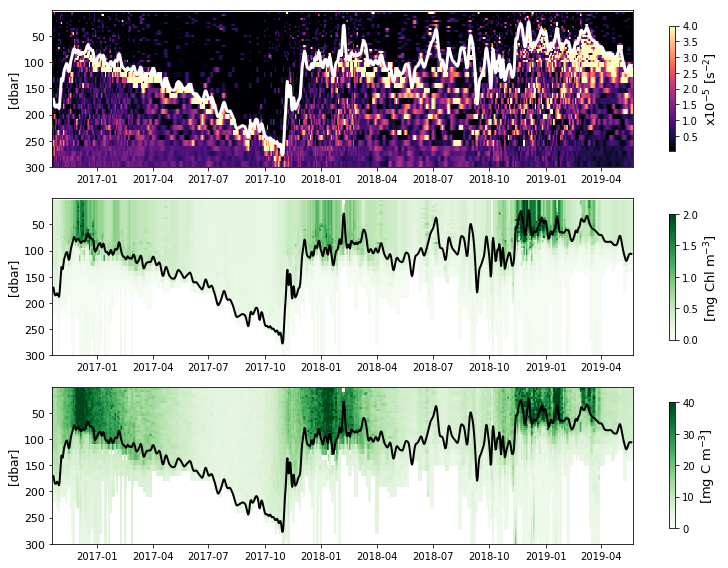

In [55]:
import matplotlib as mpl

fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(11,8))
fig.set_tight_layout(True)
im1 = ax1.pcolormesh(N2_intp.time, -pnew, N2_intp.data.T*1e5, 
                    vmin=1e-2, vmax=4e0, cmap='magma', rasterized=True)
im2 = ax2.pcolormesh(chl_intp.time, -pnew, chl_intp.data.T, 
                     vmin=0., vmax=2., cmap='Greens', rasterized=True)
im3 = ax3.pcolormesh(C_intp.time, -pnew, C_intp.data.T,
                     vmin=0., vmax=40, cmap='Greens', rasterized=True)

ax1.plot(pML_intp.time, -pML_intp.rolling(time=3, center=True).mean(), c='w', lw=3)
ax2.plot(pML_intp.time, -pML_intp.rolling(time=3, center=True).mean(), 'k', lw=2)
ax3.plot(pML_intp.time, -pML_intp.rolling(time=3, center=True).mean(), 'k', lw=2)

ax1.set_ylim([-300,0])
ax2.set_ylim([-300,0])
ax3.set_ylim([-300,0])

ax1.set_yticks([-50,-100,-150,-200,-250,-300])
ax2.set_yticks([-50,-100,-150,-200,-250,-300])
ax3.set_yticks([-50,-100,-150,-200,-250,-300])
ax1.set_yticklabels([50,100,150,200,250,300], fontsize=11)
ax2.set_yticklabels([50,100,150,200,250,300], fontsize=11)
ax3.set_yticklabels([50,100,150,200,250,300], fontsize=11)

ax1.set_ylabel(r"[dbar]", fontsize=12)
ax2.set_ylabel(r"[dbar]", fontsize=12)
ax3.set_ylabel(r"[dbar]", fontsize=12)

cb1 = fig.colorbar(im1, ax=ax1, ticks=[.5,1,1.5,2,2.5,3,3.5,4], shrink=.8)
cb2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cb3 = fig.colorbar(im3, ax=ax3, shrink=.8)

cb1.set_label(r"x10$^{-5}$ [s$^{-2}$]", fontsize=13)
cb2.set_label(r"[mg Chl m$^{-3}$]", fontsize=13)
cb3.set_label(r"[mg C m$^{-3}$]", fontsize=13)

# plt.savefig(op.join(ddir,'../Figures/SOCLIM_2739_N2-chl-C_fulltimeseries.pdf'))

In [56]:
dp = np.diff(pnew)[:24]
dp = np.append(dp, 7)
dp = np.append(dp, np.diff(pnew[24:]))

In [90]:
Cml = C_test[:,0].copy()
Cml[:] = np.nan
Chlml = chl_test[:,0].copy()
Chlml[:] = np.nan
CsML = Chlml.copy()
ChlsML = Chlml.copy()
ChlH = Chlml.copy()
Cintg = Cml.copy()
CintgH = Cml.copy()
i = 0
for tt in C_test.time.data:
    CintgH[i] = np.nansum(C_test.sel(time=tt)*dp)
    ChlH[i] = np.nansum(chl_test.sel(time=tt)*dp)
    if tt in pML_dropped.time.data:
        Cml[i] = np.nansum(C_test.sel(time=tt).where(C_test.pres<=pML_dropped.sel(time=tt))*dp)
        Chlml[i] = np.nansum(chl_test.sel(time=tt).where(chl_test.pres<=pML_dropped.sel(time=tt))*dp)
        CsML[i] = np.nansum(C_test.sel(time=tt).where(C_test.pres<=50)*dp)/50*pML_dropped.sel(time=tt)
        ChlsML[i] = np.nansum(chl_test.sel(time=tt).where(chl_test.pres<=50)*dp)/50*pML_dropped.sel(time=tt)
    i += 1

In [91]:
CintgH_tp = CintgH.interp(time=tnew, method='linear')
ChlsML_intp = ChlsML.interp(time=tnew, method='linear')
CsML_intp = CsML.interp(time=tnew, method='linear')
ChlH_intp = ChlH.interp(time=tnew, method='linear')

In [92]:
nroll = int(30/dt_intp)
if nroll % 2 == 0:
    nroll += 1
deltaT = dt_intp*86400
nroll20 = int(20/dt_intp)
if nroll20 % 2 != 0:
    nroll20 += 1

dHdt = (-pML_intp.rolling(time=nroll, center=True).mean() 
        + pML_intp.rolling(time=nroll, center=True).mean().shift(time=-nroll20)
       )[:-nroll20]/(deltaT*nroll20)

rD = pML_intp.rolling(time=nroll, center=True).mean()[int(.5*nroll20):-int(.5*nroll20)]**-1 * dHdt.data

In [93]:
dCintgHdt = (-CintgH_tp.rolling(time=nroll, center=True).mean()
             + CintgH_tp.rolling(time=nroll, center=True).mean().shift(time=-nroll20)
            )[:-nroll20]/(deltaT*nroll20)

rPH = CintgH_tp.rolling(time=nroll, center=True).mean()[int(.5*nroll20):-int(.5*nroll20)]**-1 * dCintgHdt.data

In [94]:
rPH_pos = rPH.where(rPH>=0.)
rD_pos = rD.where(rD>=0.)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


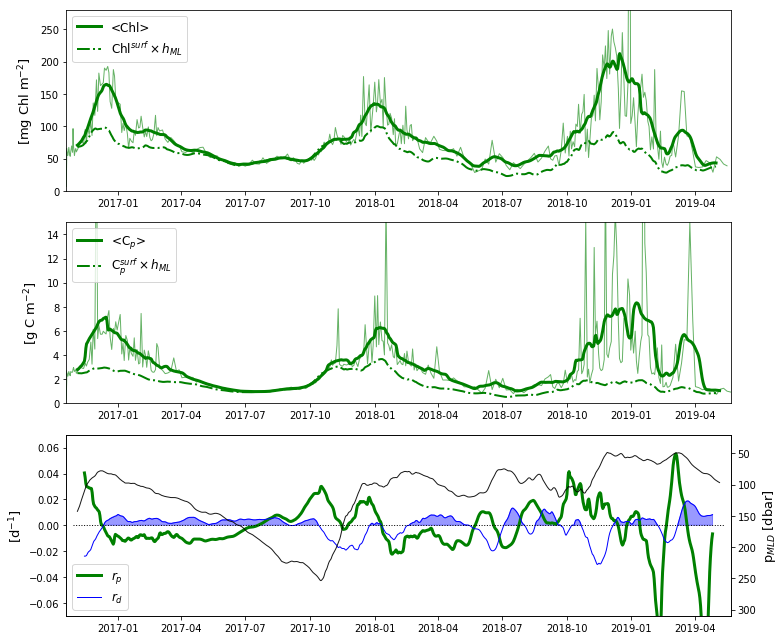

In [97]:
fig, (ax1,ax3,ax5) = plt.subplots(nrows=3, ncols=1, figsize=(11,9))
fig.set_tight_layout(True)
ax6 = ax5.twinx()

ax3.plot(CintgH.time, CintgH.data*1e-3, 'g', lw=1, alpha=.6)
ax1.plot(ChlH.time, ChlH.data, 'g', lw=1, alpha=.6)

ax1.plot(ChlH_intp.rolling(time=nroll, center=True).mean().time, 
         ChlH_intp.rolling(time=nroll, center=True).mean().data, 
         'g', lw=3, label=r"<Chl>")
ax1.plot(ChlsML_intp.rolling(time=nroll, center=True).mean().time, 
         ChlsML_intp.rolling(time=nroll, center=True).mean().data, 
         'g-.', lw=2, label=r"Chl$^{surf}\times h_{ML}$")

ax3.plot(CintgH_tp.rolling(time=nroll, center=True).mean().time, 
         CintgH_tp.rolling(time=nroll, center=True).mean().data*1e-3, 
         'g', lw=3, label=r"<C$_p$>")
ax3.plot(CsML_intp.rolling(time=nroll, center=True).mean().time, 
         CsML_intp.rolling(time=nroll, center=True).mean().data*1e-3, 
         'g-.', lw=2, label=r"C$^{surf}_p\times h_{ML}$")

ax6.plot(pML_intp.rolling(time=nroll, center=True).mean().time, 
         -pML_intp.rolling(time=nroll, center=True).mean(), 
         color='k', lw=1, alpha=.9)
ax5.plot(rPH.time.data, rPH*86400, 'g', label=r'$r_p$', lw=3)
ax5.plot(rD.time.data, rD*86400, c='b', label=r'$r_d$', lw=1)
ax5.plot(rD.time, np.zeros(len(rD.time)), 'k:', lw=1)
ax5.fill_between(np.asarray(rD_pos.time[:-1],dtype='datetime64'), rD_pos[:-1]*86400, color='b', alpha=0.4)

ax1.set_xlim([C_test.time.data[0],C_test.time.data[-1]])
ax3.set_xlim([C_test.time.data[0],C_test.time.data[-1]])
ax5.set_xlim([C_test.time.data[0],C_test.time.data[-1]])
ax6.set_ylim([-310,-20])
ax6.set_yticks([-50,-100,-150,-200,-250,-300])
ax6.set_yticklabels([50,100,150,200,250,300])
ax1.set_ylim([0,280])
ax3.set_ylim([0,15])
ax5.set_ylim([-.07,.07])
ax1.set_ylabel(r"[mg Chl m$^{-2}$]", fontsize=13)
ax3.set_ylabel(r"[g C m$^{-2}$]", fontsize=13)
ax5.set_ylabel(r"[d$^{-1}$]", fontsize=13)
ax6.set_ylabel(r"p$_{MLD}$ [dbar]", fontsize=13)
ax1.legend(loc='upper left', fontsize=12)
ax3.legend(loc='upper left', fontsize=12)
ax5.legend(loc='lower left', fontsize=12)
# plt.savefig(op.join(ddir,'../Figures/SOCLIM-2739_Cphyto-r_timeseries.pdf'))